# Component 3

In [1]:
# import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD #adam, rmsprop

from sklearn.metrics import classification_report, ConfusionMatrixDisplay

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

2023-05-01 23:35:55.013887: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# load MNIST data set
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# split train data set into validation and trainig 
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=5000, random_state=42)

In [4]:
# verify shapes
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)
print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test: ", y_test.shape)

x_val:  (5000, 28, 28)
y_val:  (5000,)
x_train:  (55000, 28, 28)
y_train:  (55000,)
x_test:  (10000, 28, 28)
y_test:  (10000,)


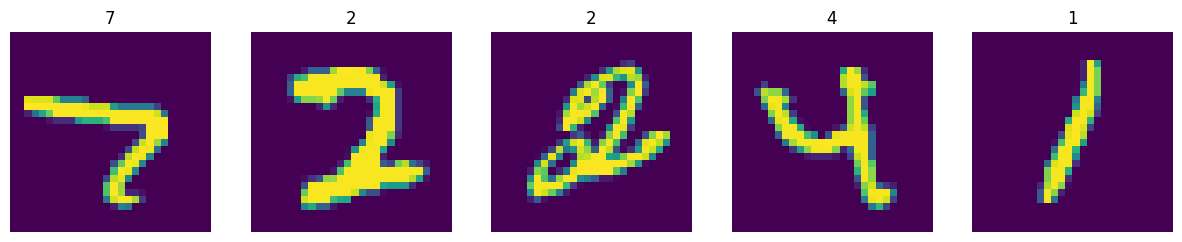

In [5]:
# explore dataset, print first 5 trainig digits
figure, axis = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    axis[i].imshow(x_train[i])
    axis[i].set_title(y_train[i])
    axis[i].axis("off")
    
plt.show()

In [6]:
# normalize dataset
x_train = x_train / 255
x_test = x_test / 255
x_val = x_val / 255

# reshape the data to have a single color channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [71]:
# get unique labels from the target variable
unique_labels = list(set(y_train))

def compile_and_fit_model(model, train_data, img_data_gen, epochs=20, learning_rate=0.001):
    """
    compile_and_fit_model compiles and fits a Keras model to the provided training data
    :arg model: Keras model to compile and fit
    :arg train_data: training data to fit the model to
    :arg img_data_gen: ImageDataGenerator to augment the training data
    :arg epochs: number of epochs to train the model for (default=20)
    :arg learning_rate: learning rate for the SGD optimizer (default=0.001)
    :return: history object containing training and validation loss and accuracy
    """
    
    # convert training and validation labels to categorical format
    categorical_y_train = keras.utils.to_categorical(y_train)
    categorical_y_val = keras.utils.to_categorical(y_val)
    
    # compile model with the specified optimizer, loss function, and metric
    model.compile(
        optimizer=SGD(learning_rate=learning_rate, momentum=0.9), 
        loss="categorical_crossentropy", 
        metrics="accuracy"
    )
    
    # fit model using the ImageDataGenerator and validation data
    return model.fit(
        img_data_gen.flow(train_data, categorical_y_train, batch_size=32),  
        validation_data=(x_val, categorical_y_val),
        epochs=epochs
    )
    

def plot_training_validation_loss(history, title="Training and Validation Loss"):
    """
    plot_training_validation_loss plots the training and validation loss over epochs
    :arg history: history object returned by model.fit()
    :arg title: title of the plot
    """
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()
    

def plot_training_validation_accuracy(history, title="Training and Validation Accuracy"):
    """
    plot_training_validation_accuracy plots the training and validation accuracy over epochs
    :arg history: history object returned by model.fit()
    :arg title: title of the plot
    """
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()
    
def predict_and_print_reports(model, title="Confusion Matrix"):
    """
    predict_and_print_reports generates predictions and prints predictions for the test dataset
    :arg model: trained model for prediction
    :arg title: title of the result plot
    """
    
    y_pred = np.argmax(model.predict(x_test), axis=-1)
    
    print(classification_report(y_test, y_pred))
    
    plt.figure(dpi=200, figsize=(10,15))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=unique_labels)
    plt.title(title)
    plt.show()
    

# Baseline Model

In [8]:
# distort and fit train images
train_datagen = ImageDataGenerator(
        zoom_range=0.1,
        shear_range=0.1,
        rotation_range=20,
        vertical_flip=True,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1
)
train_datagen.fit(x_train)

In [9]:
base_model = Sequential()
base_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
base_model.add(MaxPooling2D(pool_size=(2,2)))

base_model.add(Flatten())
base_model.add(Dense(128, activation="relu"))
base_model.add(Dropout(0.5))
base_model.add(Dense(len(unique_labels), activation="softmax"))

base_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [9]:
base_model_history = compile_and_fit_model(base_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 10:56:37.718374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 26s 15ms/step - loss: 1.8241 - accuracy: 0.3476 - val_loss: 0.9378 - val_accuracy: 0.7012
Epoch 2/20
1719/1719 [==============================] - 25s 15ms/step - loss: 1.1219 - accuracy: 0.6049 - val_loss: 0.6409 - val_accuracy: 0.7908
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.8901 - accuracy: 0.6953 - val_loss: 0.4615 - val_accuracy: 0.8668
Epoch 4/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.7540 - accuracy: 0.7463 - val_loss: 0.3922 - val_accuracy: 0.8746
Epoch 5/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.6552 - accuracy: 0.7828 - val_loss: 0.2934 - val_accuracy: 0.9084
Epoch 6/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5807 - accuracy: 0.8091 - val_loss: 0.2752 - val_accuracy: 0.9112
Epoch 7/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.5233 - accuracy: 0.8299 - val_loss: 0.2550 - val_accura

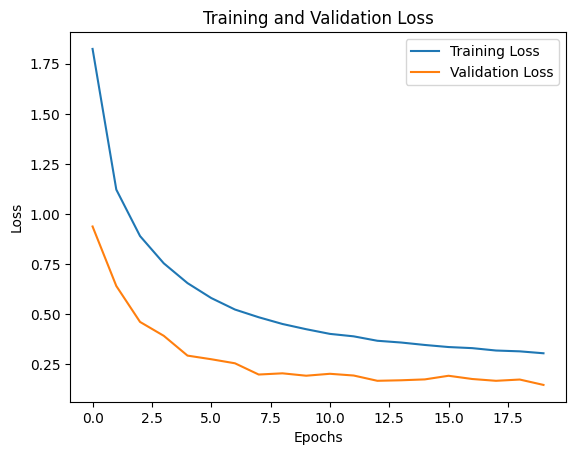

In [10]:
plot_training_validation_loss(base_model_history)

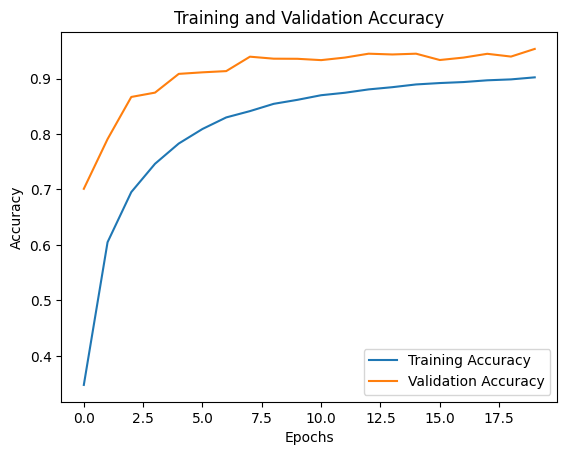

In [11]:
plot_training_validation_accuracy(base_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.89      0.95      0.92      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.99      0.98       982
           5       0.94      0.91      0.92       892
           6       0.87      0.89      0.88       958
           7       0.93      0.97      0.95      1028
           8       0.98      0.98      0.98       974
           9       0.92      0.84      0.88      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



<Figure size 2000x3000 with 0 Axes>

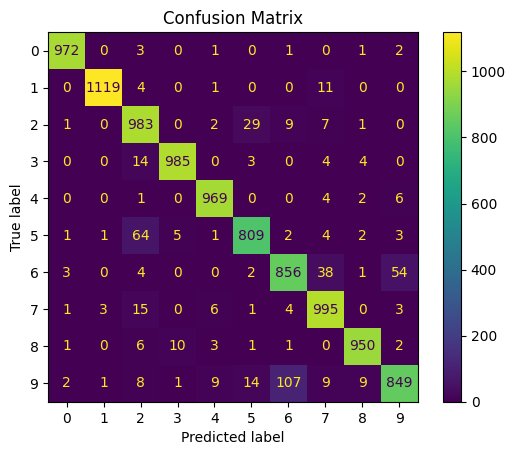

In [12]:
predict_and_print_reports(base_model)

# Experiment with different regularizers

## Data augmentation

### No augmentation

In [45]:
# distort and fit train data
no_aug_train_datagen = ImageDataGenerator()
no_aug_train_datagen.fit(x_train)

# model config
no_aug_model = Sequential()
no_aug_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
no_aug_model.add(MaxPooling2D(pool_size=(2,2)))

no_aug_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
no_aug_model.add(MaxPooling2D(pool_size=(2,2)))

no_aug_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
no_aug_model.add(MaxPooling2D(pool_size=(2,2)))

no_aug_model.add(Flatten())
no_aug_model.add(Dense(128, activation="relu"))
no_aug_model.add(Dropout(0.5))
no_aug_model.add(Dense(len(unique_labels), activation="softmax"))

no_aug_model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 2, 2, 128)      

In [46]:
no_aug_model_history = compile_and_fit_model(no_aug_model, x_train, no_aug_train_datagen, epochs=20)

Epoch 1/20


2023-05-02 06:52:51.168166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 29s 16ms/step - loss: 0.8014 - accuracy: 0.7463 - val_loss: 0.1528 - val_accuracy: 0.9534
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2076 - accuracy: 0.9365 - val_loss: 0.0985 - val_accuracy: 0.9674
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.1484 - accuracy: 0.9551 - val_loss: 0.0805 - val_accuracy: 0.9750
Epoch 4/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.1199 - accuracy: 0.9645 - val_loss: 0.0670 - val_accuracy: 0.9782
Epoch 5/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.1027 - accuracy: 0.9694 - val_loss: 0.0544 - val_accuracy: 0.9834
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.0909 - accuracy: 0.9724 - val_loss: 0.0503 - val_accuracy: 0.9856
Epoch 7/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.0782 - accuracy: 0.9765 - val_loss: 0.0490 - val_accura

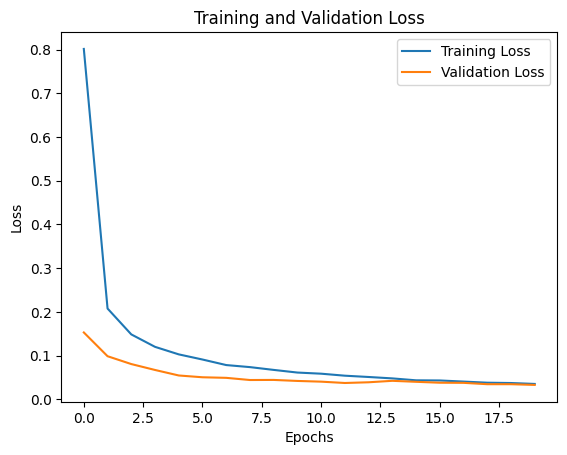

In [47]:
plot_training_validation_loss(no_aug_model_history)

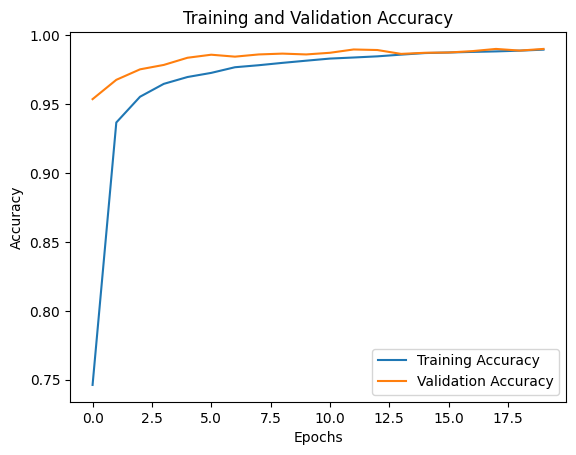

In [48]:
plot_training_validation_accuracy(no_aug_model_history)

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.99      1.00      0.99      1032
           3       0.99      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



<Figure size 2000x3000 with 0 Axes>

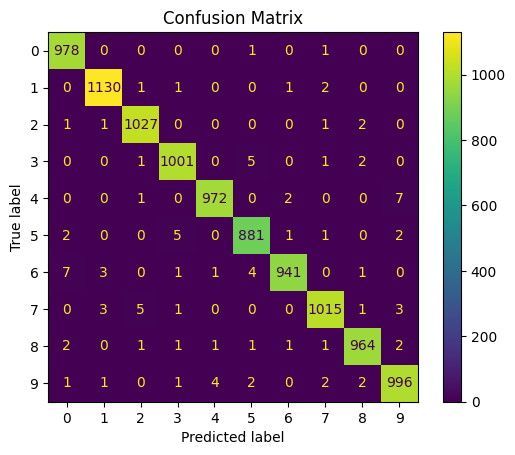

In [49]:
predict_and_print_reports(no_aug_model)

### Variant 2

In [23]:
# distort and fit train data
v_2_aug_train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=[0.8, 1.2],
    rotation_range=25,
    vertical_flip=True,
    horizontal_flip=True
)
v_2_aug_train_datagen.fit(x_train)

# model config
v_2_aug_model = Sequential()
v_2_aug_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
v_2_aug_model.add(MaxPooling2D(pool_size=(2,2)))

v_2_aug_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
v_2_aug_model.add(MaxPooling2D(pool_size=(2,2)))

v_2_aug_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
v_2_aug_model.add(MaxPooling2D(pool_size=(2,2)))

v_2_aug_model.add(Flatten())
v_2_aug_model.add(Dense(128, activation="relu"))
v_2_aug_model.add(Dropout(0.5))
v_2_aug_model.add(Dense(len(unique_labels), activation="softmax"))

v_2_aug_model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 128)       

In [24]:
v_2_aug_model_history = compile_and_fit_model(v_2_aug_model, x_train, v_2_aug_train_datagen, epochs=20)

Epoch 1/20


2023-05-01 11:43:55.320299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 26s 15ms/step - loss: 1.9054 - accuracy: 0.3197 - val_loss: 1.0251 - val_accuracy: 0.6558
Epoch 2/20
1719/1719 [==============================] - 27s 15ms/step - loss: 1.2312 - accuracy: 0.5635 - val_loss: 0.6485 - val_accuracy: 0.8130
Epoch 3/20
1719/1719 [==============================] - 42s 24ms/step - loss: 0.9951 - accuracy: 0.6539 - val_loss: 0.5293 - val_accuracy: 0.8266
Epoch 4/20
1719/1719 [==============================] - 32s 19ms/step - loss: 0.8410 - accuracy: 0.7158 - val_loss: 0.4082 - val_accuracy: 0.8682
Epoch 5/20
1719/1719 [==============================] - 30s 17ms/step - loss: 0.7338 - accuracy: 0.7553 - val_loss: 0.3271 - val_accuracy: 0.8964
Epoch 6/20
1719/1719 [==============================] - 29s 17ms/step - loss: 0.6495 - accuracy: 0.7842 - val_loss: 0.2814 - val_accuracy: 0.9090
Epoch 7/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.5946 - accuracy: 0.8048 - val_loss: 0.2399 - val_accura

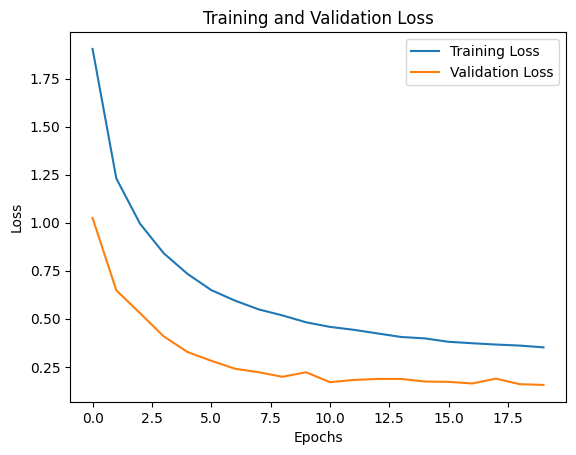

In [25]:
plot_training_validation_loss(v_2_aug_model_history)

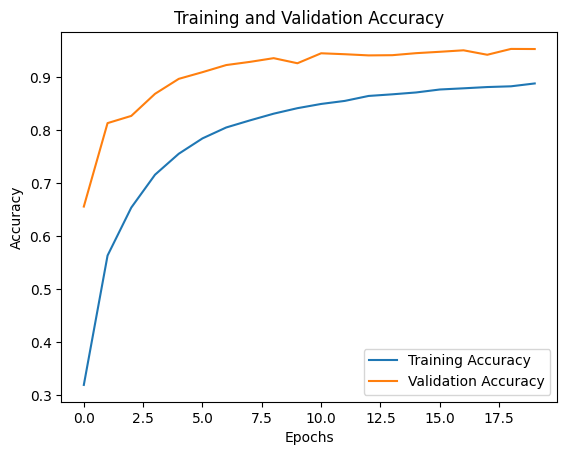

In [26]:
plot_training_validation_accuracy(v_2_aug_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.90      0.93      0.91      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.91      0.92      0.92       892
           6       0.92      0.88      0.90       958
           7       0.94      0.96      0.95      1028
           8       0.96      0.98      0.97       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



<Figure size 2000x3000 with 0 Axes>

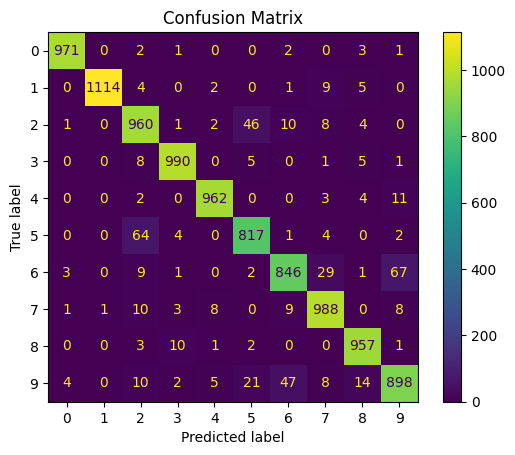

In [27]:
predict_and_print_reports(v_2_aug_model)

## Batch Normalization

### BatchNormalization added to all layers

In [28]:
all_batch_model = Sequential()

all_batch_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
all_batch_model.add(BatchNormalization())
all_batch_model.add(MaxPooling2D(pool_size=(2,2)))

all_batch_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
all_batch_model.add(BatchNormalization())
all_batch_model.add(MaxPooling2D(pool_size=(2,2)))

all_batch_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
all_batch_model.add(BatchNormalization())
all_batch_model.add(MaxPooling2D(pool_size=(2,2)))

all_batch_model.add(Flatten())
all_batch_model.add(Dense(128, activation="relu"))
all_batch_model.add(Dropout(0.5))
all_batch_model.add(Dense(len(unique_labels), activation="softmax"))

all_batch_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                      

In [29]:
all_batch_model_history = compile_and_fit_model(all_batch_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 12:06:02.024509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 41s 24ms/step - loss: 1.0574 - accuracy: 0.6370 - val_loss: 0.4328 - val_accuracy: 0.8586
Epoch 2/20
1719/1719 [==============================] - 39s 23ms/step - loss: 0.5972 - accuracy: 0.8011 - val_loss: 0.2760 - val_accuracy: 0.9148
Epoch 3/20
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4749 - accuracy: 0.8438 - val_loss: 0.2156 - val_accuracy: 0.9326
Epoch 4/20
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4120 - accuracy: 0.8652 - val_loss: 0.2109 - val_accuracy: 0.9356
Epoch 5/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.3806 - accuracy: 0.8774 - val_loss: 0.2185 - val_accuracy: 0.9302
Epoch 6/20
1719/1719 [==============================] - 40s 23ms/step - loss: 0.3491 - accuracy: 0.8880 - val_loss: 0.1701 - val_accuracy: 0.9484
Epoch 7/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.3339 - accuracy: 0.8909 - val_loss: 0.1584 - val_accura

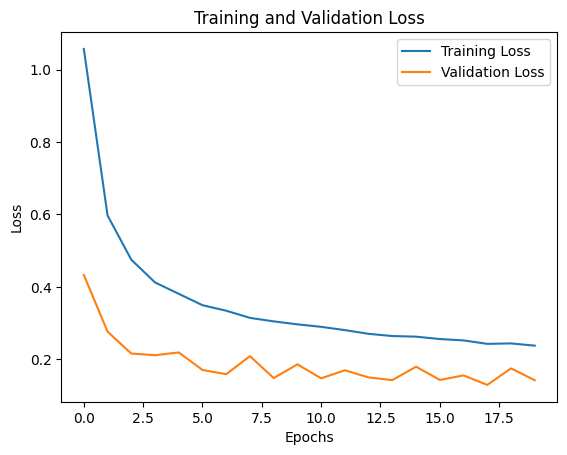

In [30]:
plot_training_validation_loss(all_batch_model_history)

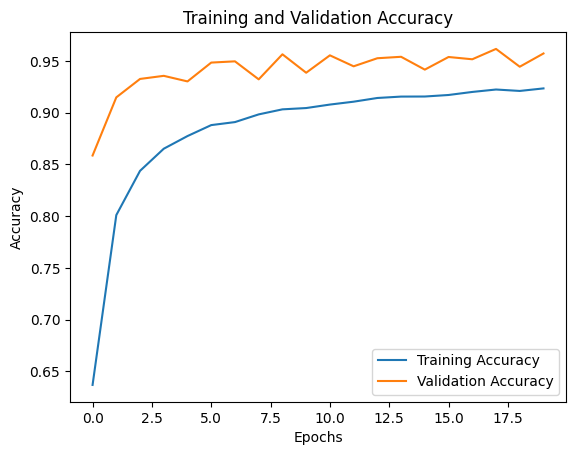

In [31]:
plot_training_validation_accuracy(all_batch_model_history)

313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.91      0.96      0.93      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.98       982
           5       0.94      0.93      0.94       892
           6       0.91      0.84      0.87       958
           7       0.95      0.98      0.96      1028
           8       1.00      0.99      0.99       974
           9       0.88      0.90      0.89      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.95      0.95     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 2000x3000 with 0 Axes>

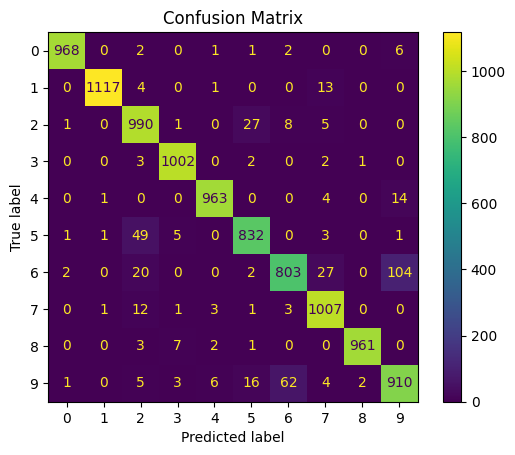

In [32]:
predict_and_print_reports(all_batch_model)

### BatchNormalization added to last layer

In [33]:
last_batch_model = Sequential()

last_batch_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
last_batch_model.add(MaxPooling2D(pool_size=(2,2)))

last_batch_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
last_batch_model.add(MaxPooling2D(pool_size=(2,2)))

last_batch_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
last_batch_model.add(BatchNormalization())
last_batch_model.add(MaxPooling2D(pool_size=(2,2)))

last_batch_model.add(Flatten())
last_batch_model.add(Dense(128, activation="relu"))
last_batch_model.add(Dropout(0.5))
last_batch_model.add(Dense(len(unique_labels), activation="softmax"))

last_batch_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 batch_normalization_3 (Batc  (None, 4, 4, 128)       

In [34]:
last_batch_model_history = compile_and_fit_model(last_batch_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 12:27:13.905608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 32s 18ms/step - loss: 1.1886 - accuracy: 0.5844 - val_loss: 0.4654 - val_accuracy: 0.8616
Epoch 2/20
1719/1719 [==============================] - 30s 17ms/step - loss: 0.6642 - accuracy: 0.7790 - val_loss: 0.2853 - val_accuracy: 0.9028
Epoch 3/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.5021 - accuracy: 0.8383 - val_loss: 0.2308 - val_accuracy: 0.9290
Epoch 4/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.4373 - accuracy: 0.8574 - val_loss: 0.2483 - val_accuracy: 0.9132
Epoch 5/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.3901 - accuracy: 0.8750 - val_loss: 0.1992 - val_accuracy: 0.9358
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3605 - accuracy: 0.8841 - val_loss: 0.2107 - val_accuracy: 0.9330
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3344 - accuracy: 0.8919 - val_loss: 0.1948 - val_accura

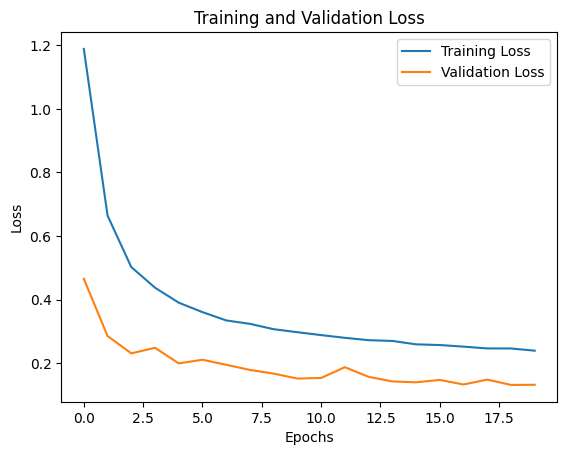

In [35]:
plot_training_validation_loss(last_batch_model_history)

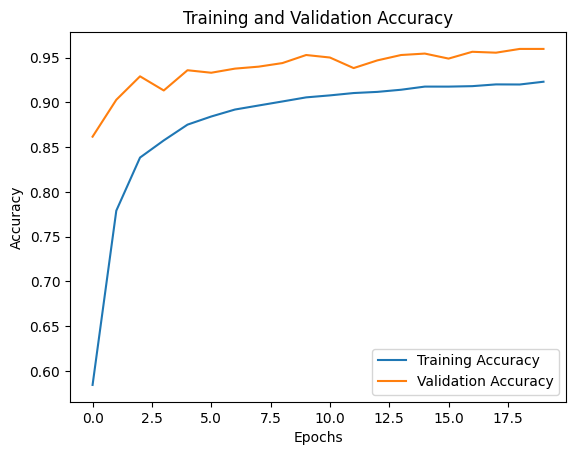

In [36]:
plot_training_validation_accuracy(last_batch_model_history)

313/313 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.91      0.96      0.93      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.97      0.98       982
           5       0.95      0.94      0.95       892
           6       0.87      0.94      0.90       958
           7       0.94      0.97      0.96      1028
           8       0.99      0.99      0.99       974
           9       0.96      0.86      0.90      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 2000x3000 with 0 Axes>

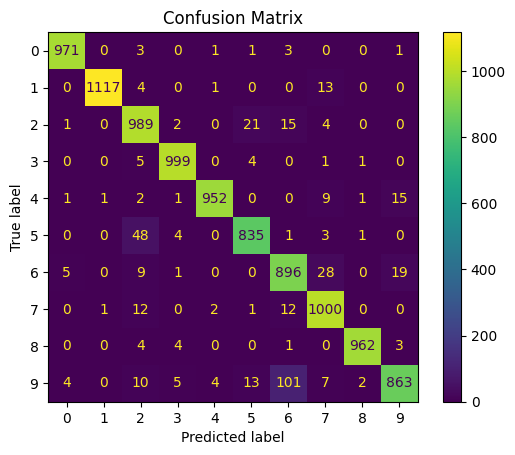

In [37]:
predict_and_print_reports(last_batch_model)

## Dropout

### No Dropout

In [38]:
no_drop_model = Sequential()
no_drop_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
no_drop_model.add(MaxPooling2D(pool_size=(2,2)))

no_drop_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
no_drop_model.add(MaxPooling2D(pool_size=(2,2)))

no_drop_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
no_drop_model.add(MaxPooling2D(pool_size=(2,2)))

no_drop_model.add(Flatten())
no_drop_model.add(Dense(128, activation="relu"))
no_drop_model.add(Dense(len(unique_labels), activation="softmax"))

no_drop_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 2, 2, 128)       

In [39]:
no_drop_model_history = compile_and_fit_model(no_drop_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 12:47:47.436426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 25s 14ms/step - loss: 1.6958 - accuracy: 0.4137 - val_loss: 0.7696 - val_accuracy: 0.7362
Epoch 2/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.8915 - accuracy: 0.6964 - val_loss: 0.4839 - val_accuracy: 0.8488
Epoch 3/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.6414 - accuracy: 0.7873 - val_loss: 0.3566 - val_accuracy: 0.8874
Epoch 4/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.4985 - accuracy: 0.8348 - val_loss: 0.3618 - val_accuracy: 0.8876
Epoch 5/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.4202 - accuracy: 0.8623 - val_loss: 0.2809 - val_accuracy: 0.9062
Epoch 6/20
1719/1719 [==============================] - 24s 14ms/step - loss: 0.3700 - accuracy: 0.8771 - val_loss: 0.2299 - val_accuracy: 0.9282
Epoch 7/20
1719/1719 [==============================] - 25s 14ms/step - loss: 0.3335 - accuracy: 0.8891 - val_loss: 0.2078 - val_accura

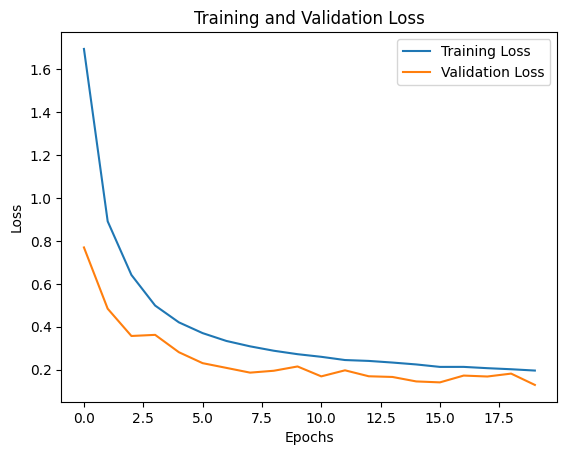

In [40]:
plot_training_validation_loss(no_drop_model_history)

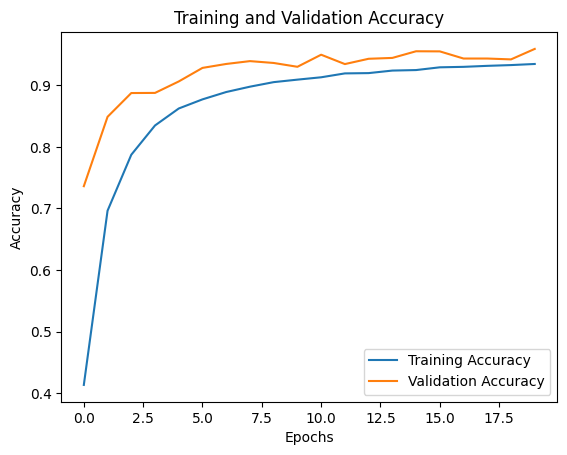

In [41]:
plot_training_validation_accuracy(no_drop_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.93      0.85      0.89      1032
           3       0.99      0.98      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.82      0.95      0.88       892
           6       0.97      0.92      0.95       958
           7       0.95      0.97      0.96      1028
           8       0.98      0.99      0.98       974
           9       0.94      0.93      0.93      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.96      0.95      0.96     10000



<Figure size 2000x3000 with 0 Axes>

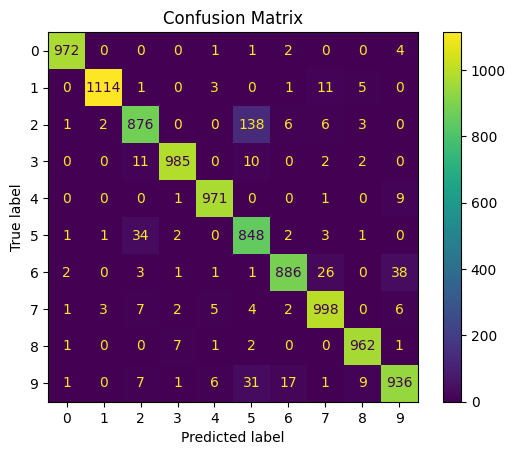

In [42]:
predict_and_print_reports(no_drop_model)

### 0.25 Dropout

In [44]:
point_25_drop_model = Sequential()
point_25_drop_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_25_drop_model.add(MaxPooling2D(pool_size=(2,2)))

point_25_drop_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_25_drop_model.add(MaxPooling2D(pool_size=(2,2)))

point_25_drop_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_25_drop_model.add(MaxPooling2D(pool_size=(2,2)))

point_25_drop_model.add(Flatten())
point_25_drop_model.add(Dense(128, activation="relu"))
point_25_drop_model.add(Dropout(0.25))
point_25_drop_model.add(Dense(len(unique_labels), activation="softmax"))

point_25_drop_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 128)       

In [45]:
point_25_drop_model_history = compile_and_fit_model(point_25_drop_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 13:07:13.541100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 29s 17ms/step - loss: 1.7858 - accuracy: 0.3655 - val_loss: 0.8149 - val_accuracy: 0.7418
Epoch 2/20
1719/1719 [==============================] - 30s 18ms/step - loss: 0.9868 - accuracy: 0.6573 - val_loss: 0.5561 - val_accuracy: 0.8182
Epoch 3/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7296 - accuracy: 0.7575 - val_loss: 0.3785 - val_accuracy: 0.8782
Epoch 4/20
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5922 - accuracy: 0.8037 - val_loss: 0.2881 - val_accuracy: 0.9096
Epoch 5/20
1719/1719 [==============================] - 29s 17ms/step - loss: 0.5098 - accuracy: 0.8323 - val_loss: 0.2725 - val_accuracy: 0.9122
Epoch 6/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4500 - accuracy: 0.8528 - val_loss: 0.2257 - val_accuracy: 0.9260
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.4079 - accuracy: 0.8652 - val_loss: 0.2204 - val_accura

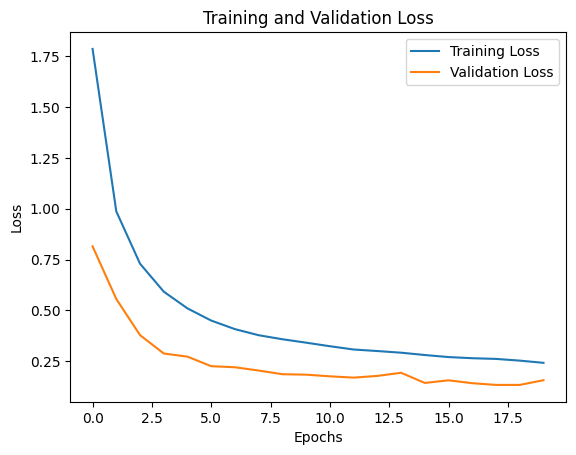

In [46]:
plot_training_validation_loss(point_25_drop_model_history)

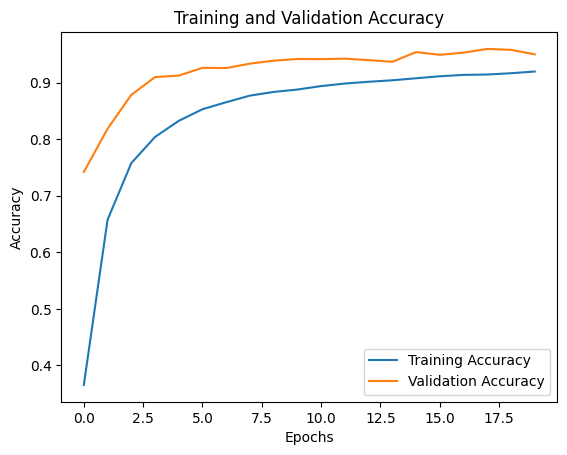

In [47]:
plot_training_validation_accuracy(point_25_drop_model_history)

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.98      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.91      0.96      0.94       892
           6       0.89      0.82      0.85       958
           7       0.91      0.97      0.94      1028
           8       0.99      0.98      0.98       974
           9       0.89      0.87      0.88      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



<Figure size 2000x3000 with 0 Axes>

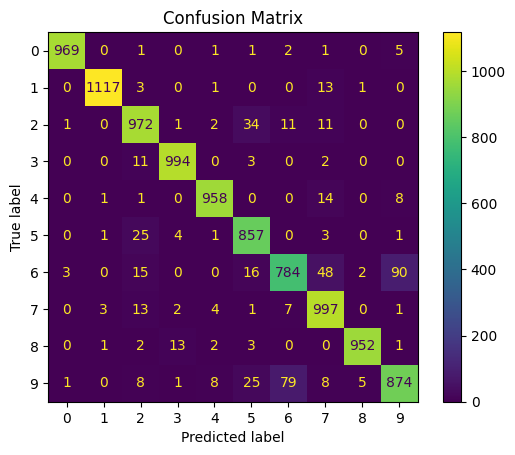

In [48]:
predict_and_print_reports(point_25_drop_model)

## L1 & L2 Regularizers

### L1 Regularizer

In [75]:
l1_reg_model = Sequential()
l1_reg_model.add(
    Conv2D(
        filters=32, 
        kernel_size=(3,3), 
        input_shape=x_train[0].shape, 
        activation="relu",
        padding="same"
    )
)
l1_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l1_reg_model.add(
    Conv2D(filters=64, kernel_size=(3,3), activation="relu")
)
l1_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l1_reg_model.add(
    Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.01))
)
l1_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l1_reg_model.add(Flatten())
l1_reg_model.add(Dense(128, activation="relu"))
l1_reg_model.add(Dropout(0.5))
l1_reg_model.add(Dense(len(unique_labels), activation="softmax"))

l1_reg_model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_46 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_47 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_47 (MaxPoolin  (None, 2, 2, 128)      

In [76]:
l1_reg_model_history = compile_and_fit_model(l1_reg_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 18:52:10.971208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 28s 16ms/step - loss: 4.9183 - accuracy: 0.1367 - val_loss: 2.3123 - val_accuracy: 0.1070
Epoch 2/20
1719/1719 [==============================] - 27s 15ms/step - loss: 2.3108 - accuracy: 0.1127 - val_loss: 2.3116 - val_accuracy: 0.1070
Epoch 3/20
1719/1719 [==============================] - 28s 16ms/step - loss: 2.3103 - accuracy: 0.1129 - val_loss: 2.3111 - val_accuracy: 0.1070
Epoch 4/20
1719/1719 [==============================] - 29s 17ms/step - loss: 2.3100 - accuracy: 0.1129 - val_loss: 2.3110 - val_accuracy: 0.1070
Epoch 5/20
1719/1719 [==============================] - 29s 17ms/step - loss: 2.3099 - accuracy: 0.1129 - val_loss: 2.3109 - val_accuracy: 0.1070
Epoch 6/20
1719/1719 [==============================] - 29s 17ms/step - loss: 2.3098 - accuracy: 0.1129 - val_loss: 2.3110 - val_accuracy: 0.1070
Epoch 7/20
1719/1719 [==============================] - 29s 17ms/step - loss: 2.3097 - accuracy: 0.1129 - val_loss: 2.3109 - val_accura

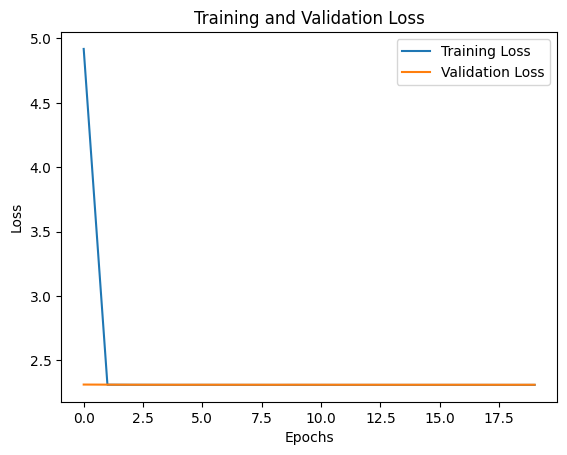

In [77]:
plot_training_validation_loss(l1_reg_model_history)

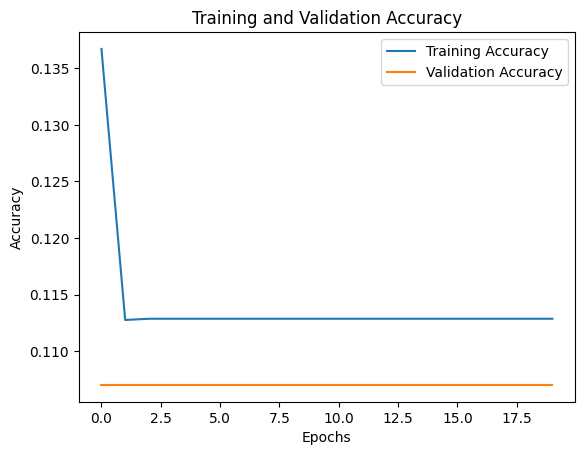

In [78]:
plot_training_validation_accuracy(l1_reg_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.11      1.00      0.20      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.11     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.11      0.02     10000



<Figure size 2000x3000 with 0 Axes>

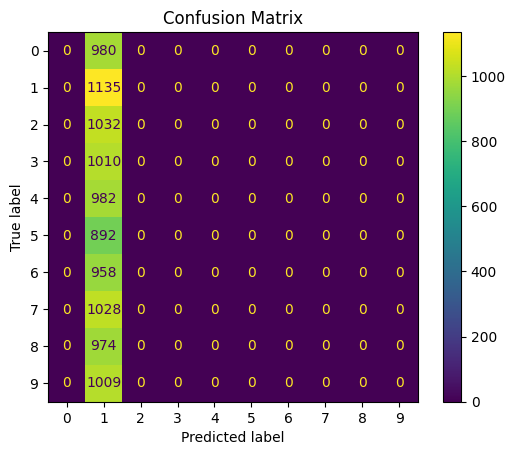

In [79]:
predict_and_print_reports(l1_reg_model)

### L2 Regularizer

In [70]:
l2_reg_model = Sequential()
l2_reg_model.add(
    Conv2D(
        filters=32, 
        kernel_size=(3,3), 
        input_shape=x_train[0].shape, 
        activation="relu",
        padding="same"
    )
)
l2_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l2_reg_model.add(
    Conv2D(filters=64, kernel_size=(3,3), activation="relu")
)
l2_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l2_reg_model.add(
    Conv2D(filters=128, kernel_size=(3,3), activation="relu", kernel_regularizer=keras.regularizers.l2(l=0.01))
)
l2_reg_model.add(MaxPooling2D(pool_size=(2,2)))

l2_reg_model.add(Flatten())
l2_reg_model.add(Dense(128, activation="relu"))
l2_reg_model.add(Dropout(0.5))
l2_reg_model.add(Dense(len(unique_labels), activation="softmax"))

l2_reg_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_44 (MaxPoolin  (None, 2, 2, 128)      

In [71]:
l2_reg_model_history = compile_and_fit_model(l2_reg_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 18:21:19.343069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 27s 16ms/step - loss: 2.5802 - accuracy: 0.3038 - val_loss: 1.5538 - val_accuracy: 0.6332
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 1.5516 - accuracy: 0.5761 - val_loss: 0.9224 - val_accuracy: 0.7800
Epoch 3/20
1719/1719 [==============================] - 27s 16ms/step - loss: 1.1565 - accuracy: 0.6781 - val_loss: 0.8296 - val_accuracy: 0.7784
Epoch 4/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.9342 - accuracy: 0.7388 - val_loss: 0.5233 - val_accuracy: 0.8794
Epoch 5/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.8016 - accuracy: 0.7752 - val_loss: 0.4129 - val_accuracy: 0.9122
Epoch 6/20
1719/1719 [==============================] - 65s 38ms/step - loss: 0.7201 - accuracy: 0.7995 - val_loss: 0.4003 - val_accuracy: 0.9100
Epoch 7/20
1719/1719 [==============================] - 35s 20ms/step - loss: 0.6563 - accuracy: 0.8176 - val_loss: 0.3837 - val_accura

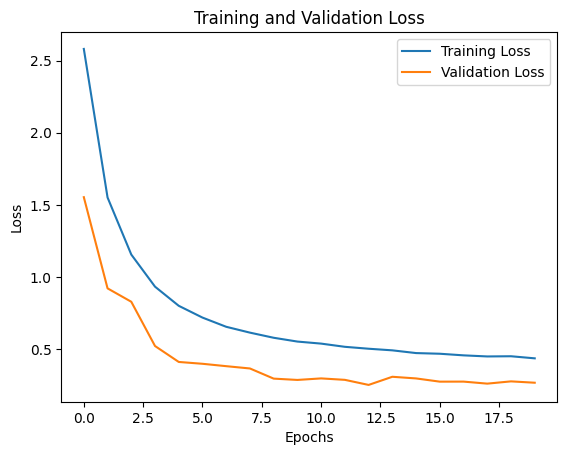

In [72]:
plot_training_validation_loss(l2_reg_model_history)

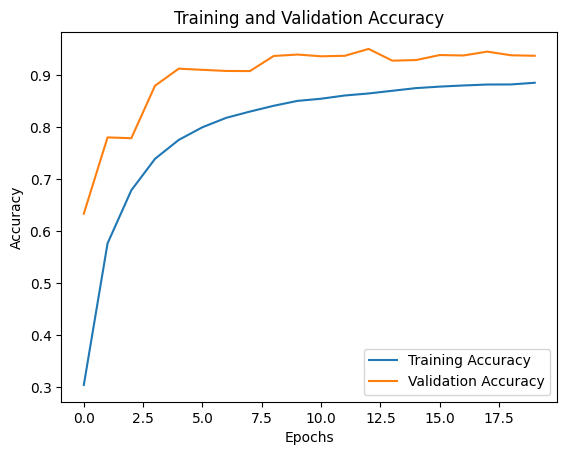

In [73]:
plot_training_validation_accuracy(l2_reg_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.89      0.91      0.90      1032
           3       0.98      0.98      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.94      0.90      0.92       892
           6       0.81      0.84      0.83       958
           7       0.94      0.94      0.94      1028
           8       0.98      0.99      0.98       974
           9       0.87      0.85      0.86      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



<Figure size 2000x3000 with 0 Axes>

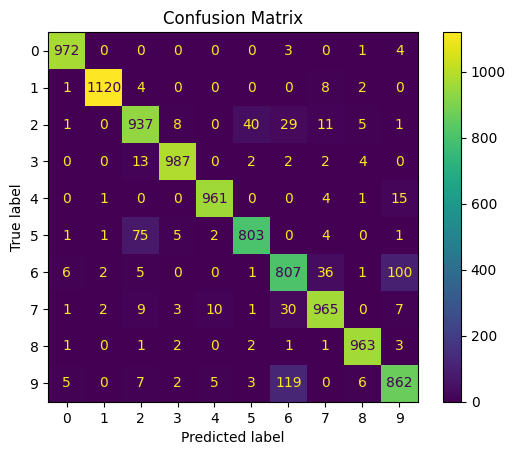

In [74]:
predict_and_print_reports(l2_reg_model)

# Section 3B


### 2 Convolution blocks

In [80]:
conv_2_model = Sequential()
conv_2_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
conv_2_model.add(MaxPooling2D(pool_size=(2,2)))

conv_2_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
conv_2_model.add(MaxPooling2D(pool_size=(2,2)))

conv_2_model.add(Flatten())
conv_2_model.add(Dense(128, activation="relu"))
conv_2_model.add(Dropout(0.5))
conv_2_model.add(Dense(len(unique_labels), activation="softmax"))

conv_2_model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 flatten_16 (Flatten)        (None, 2304)              0         
                                                                 
 dense_32 (Dense)            (None, 128)             

In [81]:
conv_2_model_history = compile_and_fit_model(conv_2_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 19:31:43.503539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 28s 16ms/step - loss: 1.8473 - accuracy: 0.3357 - val_loss: 1.0126 - val_accuracy: 0.6980
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 1.2431 - accuracy: 0.5587 - val_loss: 0.6907 - val_accuracy: 0.7968
Epoch 3/20
1719/1719 [==============================] - 27s 15ms/step - loss: 1.0191 - accuracy: 0.6452 - val_loss: 0.5591 - val_accuracy: 0.8374
Epoch 4/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9004 - accuracy: 0.6901 - val_loss: 0.4946 - val_accuracy: 0.8550
Epoch 5/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.8222 - accuracy: 0.7218 - val_loss: 0.3890 - val_accuracy: 0.8850
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7667 - accuracy: 0.7409 - val_loss: 0.3614 - val_accuracy: 0.8890
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.7168 - accuracy: 0.7568 - val_loss: 0.3621 - val_accura

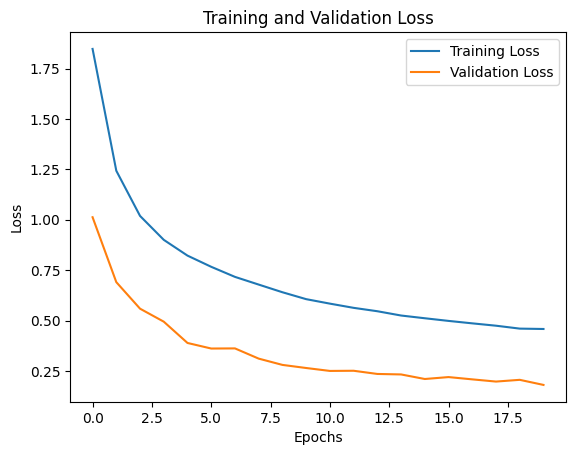

In [82]:
plot_training_validation_loss(conv_2_model_history)

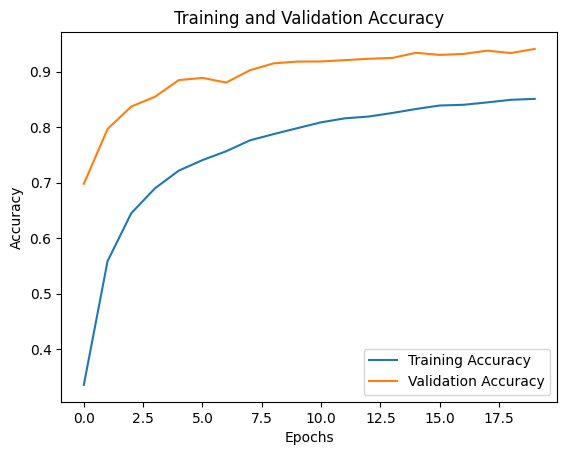

In [83]:
plot_training_validation_accuracy(conv_2_model_history)

313/313 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.90      0.91      0.90      1032
           3       0.98      0.96      0.97      1010
           4       0.98      0.98      0.98       982
           5       0.90      0.93      0.92       892
           6       0.93      0.84      0.88       958
           7       0.94      0.96      0.95      1028
           8       0.96      0.98      0.97       974
           9       0.87      0.90      0.88      1009

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



<Figure size 2000x3000 with 0 Axes>

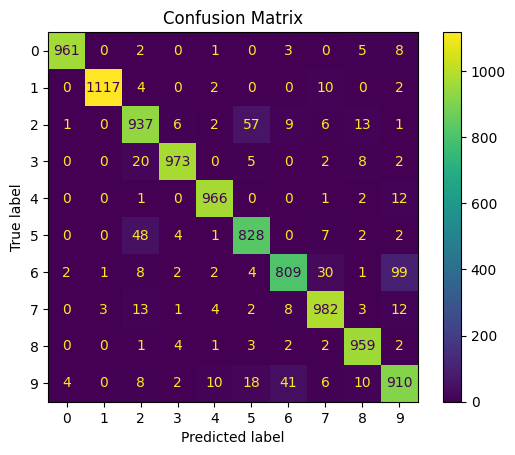

In [84]:
predict_and_print_reports(conv_2_model)

### 4 Convolution blocks

In [9]:
conv_4_model = Sequential()
conv_4_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
conv_4_model.add(MaxPooling2D(pool_size=(2,2)))

conv_4_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
conv_4_model.add(MaxPooling2D(pool_size=(2,2)))

conv_4_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"))
conv_4_model.add(MaxPooling2D(pool_size=(2,2)))

conv_4_model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"))
conv_4_model.add(MaxPooling2D(pool_size=(2,2)))

conv_4_model.add(Flatten())
conv_4_model.add(Dense(128, activation="relu"))
conv_4_model.add(Dropout(0.5))
conv_4_model.add(Dense(len(unique_labels), activation="softmax"))

conv_4_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 128)        0

In [12]:
conv_4_model_history = compile_and_fit_model(conv_4_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 20:08:40.039802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 40s 23ms/step - loss: 1.9947 - accuracy: 0.2869 - val_loss: 1.0616 - val_accuracy: 0.6552
Epoch 2/20
1719/1719 [==============================] - 41s 24ms/step - loss: 1.1265 - accuracy: 0.5965 - val_loss: 0.7106 - val_accuracy: 0.7594
Epoch 3/20
1719/1719 [==============================] - 42s 24ms/step - loss: 0.8289 - accuracy: 0.7124 - val_loss: 0.4616 - val_accuracy: 0.8514
Epoch 4/20
1719/1719 [==============================] - 42s 25ms/step - loss: 0.6593 - accuracy: 0.7805 - val_loss: 0.3206 - val_accuracy: 0.9004
Epoch 5/20
1719/1719 [==============================] - 43s 25ms/step - loss: 0.5496 - accuracy: 0.8200 - val_loss: 0.3123 - val_accuracy: 0.9004
Epoch 6/20
1719/1719 [==============================] - 42s 25ms/step - loss: 0.4724 - accuracy: 0.8476 - val_loss: 0.2599 - val_accuracy: 0.9164
Epoch 7/20
1719/1719 [==============================] - 45s 26ms/step - loss: 0.4260 - accuracy: 0.8630 - val_loss: 0.2173 - val_accura

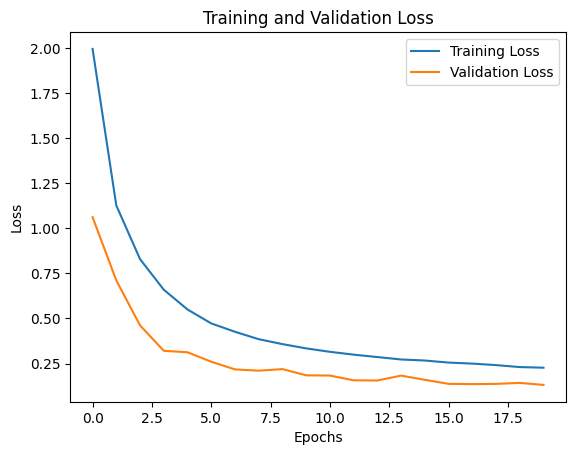

In [13]:
plot_training_validation_loss(conv_4_model_history)

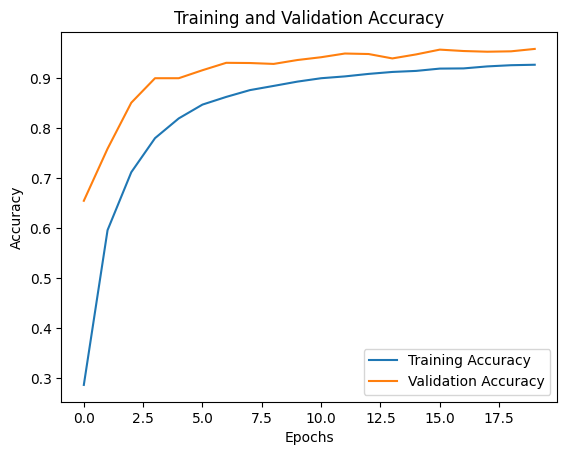

In [14]:
plot_training_validation_accuracy(conv_4_model_history)

313/313 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.98      0.99      1135
           2       0.92      0.94      0.93      1032
           3       0.98      0.97      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.94      0.93      0.94       892
           6       0.90      0.92      0.91       958
           7       0.95      0.96      0.96      1028
           8       0.96      0.99      0.98       974
           9       0.93      0.88      0.90      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 2000x3000 with 0 Axes>

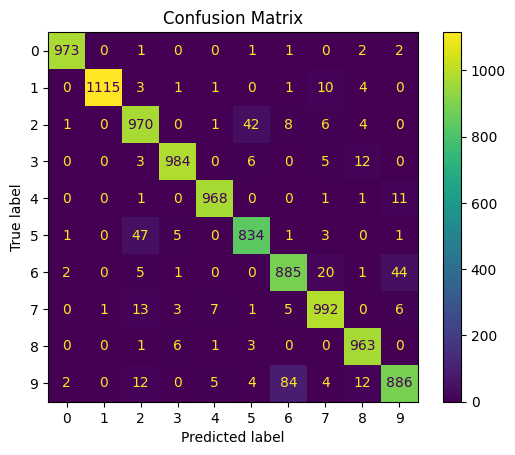

In [15]:
predict_and_print_reports(conv_4_model)

### 5 Convolution blocks

In [17]:
conv_5_model = Sequential()
conv_5_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
conv_5_model.add(MaxPooling2D(pool_size=(2,2)))

conv_5_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"))
conv_5_model.add(MaxPooling2D(pool_size=(2,2)))

conv_5_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"))
conv_5_model.add(MaxPooling2D(pool_size=(2,2)))

conv_5_model.add(Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"))
conv_5_model.add(MaxPooling2D(pool_size=(2,2)))

conv_5_model.add(Conv2D(filters=512, kernel_size=(3,3), activation="relu", padding="same"))
conv_5_model.add(MaxPooling2D(pool_size=(2,2), padding="same"))

conv_5_model.add(Flatten())
conv_5_model.add(Dense(512, activation="relu"))
conv_5_model.add(Dropout(0.5))
conv_5_model.add(Dense(len(unique_labels), activation="softmax"))

conv_5_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 7, 7, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 7, 7, 128)         73856     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 3, 3, 128)       

In [18]:
conv_5_model_history = compile_and_fit_model(conv_5_model, x_train, train_datagen, epochs=20)

Epoch 1/20


2023-05-01 20:34:34.085077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 130s 76ms/step - loss: 2.2856 - accuracy: 0.1578 - val_loss: 2.1880 - val_accuracy: 0.2432
Epoch 2/20
1719/1719 [==============================] - 127s 74ms/step - loss: 1.6381 - accuracy: 0.3989 - val_loss: 0.9156 - val_accuracy: 0.6714
Epoch 3/20
1719/1719 [==============================] - 129s 75ms/step - loss: 0.9459 - accuracy: 0.6585 - val_loss: 0.5819 - val_accuracy: 0.8098
Epoch 4/20
1719/1719 [==============================] - 129s 75ms/step - loss: 0.6673 - accuracy: 0.7666 - val_loss: 0.4347 - val_accuracy: 0.8508
Epoch 5/20
1719/1719 [==============================] - 127s 74ms/step - loss: 0.5129 - accuracy: 0.8277 - val_loss: 0.2862 - val_accuracy: 0.9046
Epoch 6/20
1719/1719 [==============================] - 129s 75ms/step - loss: 0.4171 - accuracy: 0.8610 - val_loss: 0.2456 - val_accuracy: 0.9210
Epoch 7/20
1719/1719 [==============================] - 128s 74ms/step - loss: 0.3679 - accuracy: 0.8778 - val_loss: 0.2553 - val

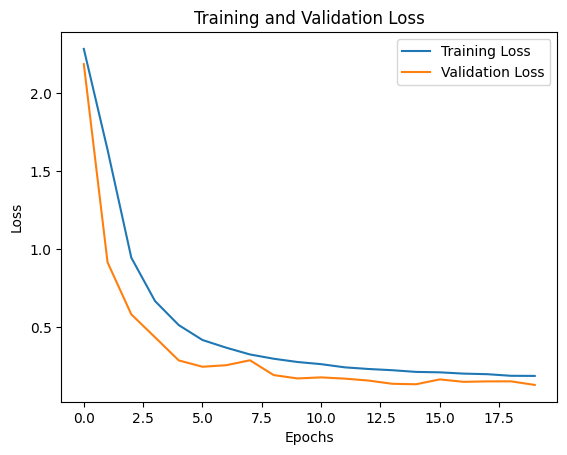

In [19]:
plot_training_validation_loss(conv_5_model_history)

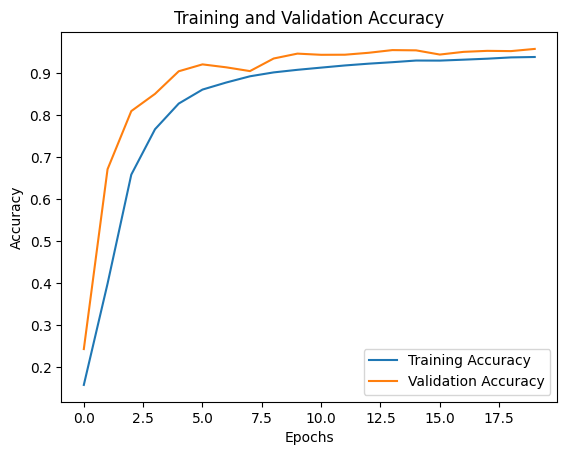

In [20]:
plot_training_validation_accuracy(conv_5_model_history)

313/313 [==============================] - 2s 7ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.92      0.94      1032
           3       0.98      0.98      0.98      1010
           4       0.99      0.97      0.98       982
           5       0.94      0.96      0.95       892
           6       0.92      0.89      0.91       958
           7       0.93      0.97      0.95      1028
           8       0.99      0.98      0.98       974
           9       0.90      0.92      0.91      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 2000x3000 with 0 Axes>

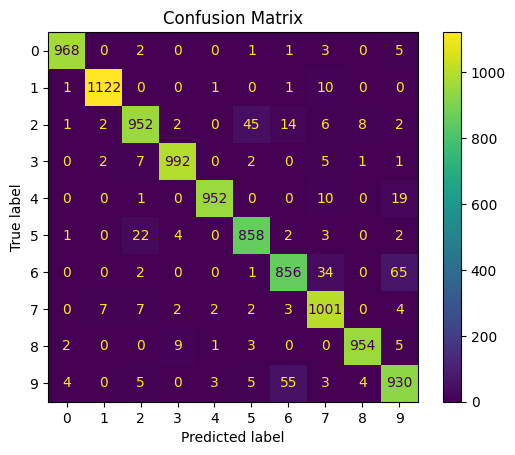

In [21]:
predict_and_print_reports(conv_5_model)

# Section 3C


### Learning rate: 0.0001

In [9]:
point_0001_model = Sequential()
point_0001_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_0001_model.add(MaxPooling2D(pool_size=(2,2)))

point_0001_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_0001_model.add(MaxPooling2D(pool_size=(2,2)))

point_0001_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_0001_model.add(MaxPooling2D(pool_size=(2,2)))

point_0001_model.add(Flatten())
point_0001_model.add(Dense(128, activation="relu"))
point_0001_model.add(Dropout(0.5))
point_0001_model.add(Dense(len(unique_labels), activation="softmax"))

point_0001_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [10]:
point_0001_model_history = compile_and_fit_model(
    point_0001_model, x_train, train_datagen, epochs=20, learning_rate=0.0001
)

Epoch 1/20


2023-05-01 23:36:40.596186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 27s 15ms/step - loss: 2.2952 - accuracy: 0.1390 - val_loss: 2.2737 - val_accuracy: 0.2194
Epoch 2/20
1719/1719 [==============================] - 28s 16ms/step - loss: 2.2634 - accuracy: 0.2076 - val_loss: 2.2149 - val_accuracy: 0.3436
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 2.1838 - accuracy: 0.2590 - val_loss: 2.0220 - val_accuracy: 0.3910
Epoch 4/20
1719/1719 [==============================] - 26s 15ms/step - loss: 2.0054 - accuracy: 0.3040 - val_loss: 1.7121 - val_accuracy: 0.4514
Epoch 5/20
1719/1719 [==============================] - 26s 15ms/step - loss: 1.8298 - accuracy: 0.3529 - val_loss: 1.4674 - val_accuracy: 0.5646
Epoch 6/20
1719/1719 [==============================] - 27s 15ms/step - loss: 1.6752 - accuracy: 0.4047 - val_loss: 1.2683 - val_accuracy: 0.6282
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 1.5309 - accuracy: 0.4560 - val_loss: 1.1075 - val_accura

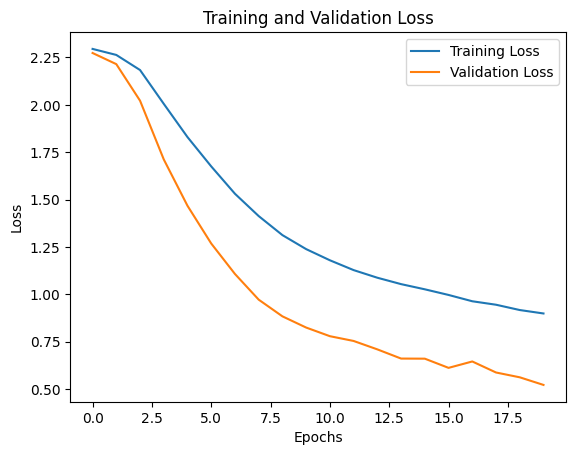

In [11]:
plot_training_validation_loss(point_0001_model_history)

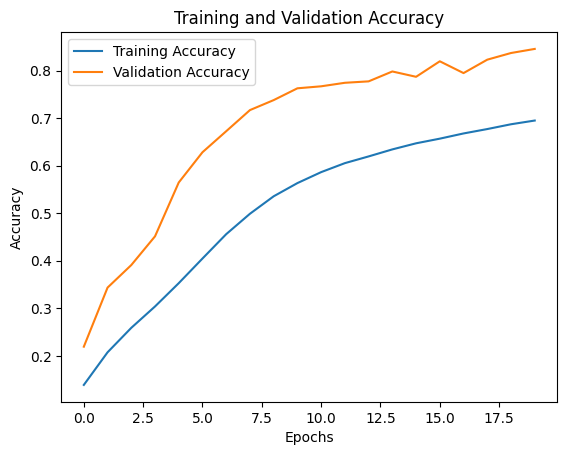

In [12]:
plot_training_validation_accuracy(point_0001_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       980
           1       0.97      0.98      0.98      1135
           2       0.88      0.69      0.78      1032
           3       0.77      0.80      0.79      1010
           4       0.96      0.90      0.93       982
           5       0.73      0.76      0.75       892
           6       0.72      0.68      0.70       958
           7       0.84      0.86      0.85      1028
           8       0.87      0.91      0.89       974
           9       0.74      0.84      0.79      1009

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.85      0.84      0.84     10000



<Figure size 2000x3000 with 0 Axes>

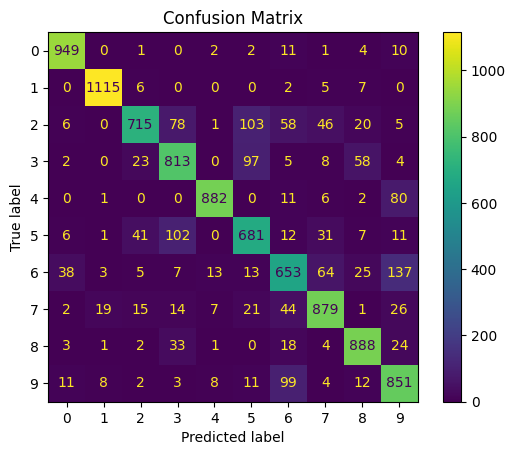

In [13]:
predict_and_print_reports(point_0001_model)

### Learning rate: 0.01

In [14]:
point_01_model = Sequential()
point_01_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_01_model.add(MaxPooling2D(pool_size=(2,2)))

point_01_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_01_model.add(MaxPooling2D(pool_size=(2,2)))

point_01_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_01_model.add(MaxPooling2D(pool_size=(2,2)))

point_01_model.add(Flatten())
point_01_model.add(Dense(128, activation="relu"))
point_01_model.add(Dropout(0.5))
point_01_model.add(Dense(len(unique_labels), activation="softmax"))

point_01_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 128)       

In [15]:
point_01_model_history = compile_and_fit_model(
    point_01_model, x_train, train_datagen, epochs=20, learning_rate=0.01
)

Epoch 1/20


2023-05-01 23:47:05.784318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 27s 15ms/step - loss: 1.1036 - accuracy: 0.6063 - val_loss: 0.3457 - val_accuracy: 0.8894
Epoch 2/20
1719/1719 [==============================] - 25s 15ms/step - loss: 0.5127 - accuracy: 0.8320 - val_loss: 0.2034 - val_accuracy: 0.9376
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3977 - accuracy: 0.8695 - val_loss: 0.2233 - val_accuracy: 0.9220
Epoch 4/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3513 - accuracy: 0.8865 - val_loss: 0.2055 - val_accuracy: 0.9292
Epoch 5/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3125 - accuracy: 0.8991 - val_loss: 0.1520 - val_accuracy: 0.9560
Epoch 6/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2948 - accuracy: 0.9058 - val_loss: 0.1782 - val_accuracy: 0.9442
Epoch 7/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2754 - accuracy: 0.9113 - val_loss: 0.1440 - val_accura

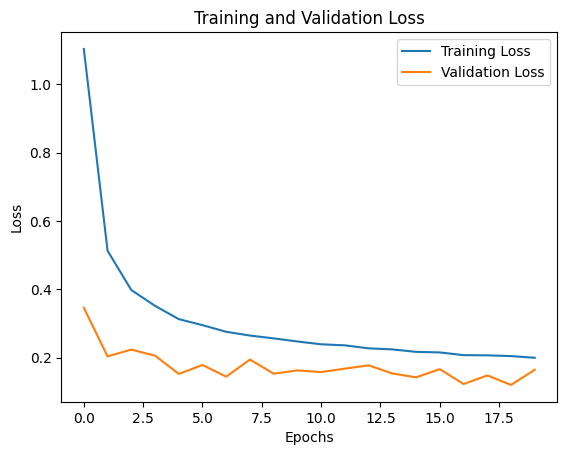

In [16]:
plot_training_validation_loss(point_01_model_history)

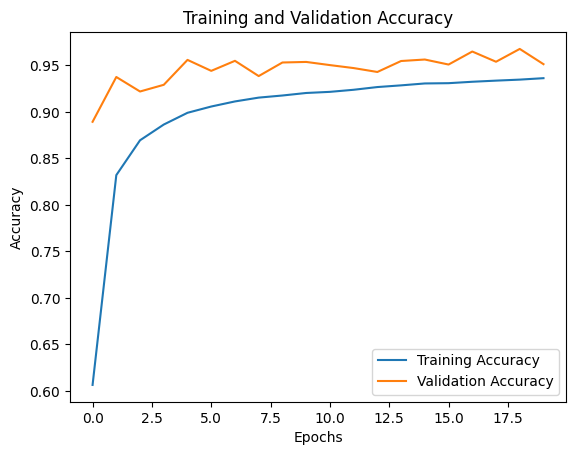

In [17]:
plot_training_validation_accuracy(point_01_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       980
           1       1.00      0.96      0.98      1135
           2       0.91      0.94      0.92      1032
           3       0.97      1.00      0.98      1010
           4       0.98      0.99      0.99       982
           5       0.94      0.93      0.93       892
           6       0.93      0.84      0.88       958
           7       0.96      0.97      0.97      1028
           8       0.96      1.00      0.98       974
           9       0.88      0.92      0.90      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



<Figure size 2000x3000 with 0 Axes>

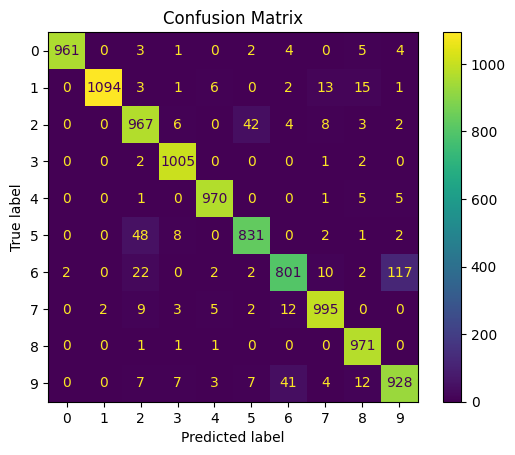

In [18]:
predict_and_print_reports(point_01_model)

### Learning rate: 0.05

In [28]:
point_05_model = Sequential()
point_05_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_05_model.add(MaxPooling2D(pool_size=(2,2)))

point_05_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_05_model.add(MaxPooling2D(pool_size=(2,2)))

point_05_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_05_model.add(MaxPooling2D(pool_size=(2,2)))

point_05_model.add(Flatten())
point_05_model.add(Dense(128, activation="relu"))
point_05_model.add(Dropout(0.5))
point_05_model.add(Dense(len(unique_labels), activation="softmax"))

point_05_model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 2, 2, 128)       

In [29]:
point_05_model_history = compile_and_fit_model(
    point_05_model, x_train, train_datagen, epochs=20, learning_rate=0.05
)

Epoch 1/20


2023-05-02 06:12:37.620936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 28s 16ms/step - loss: 1.1628 - accuracy: 0.5973 - val_loss: 0.5841 - val_accuracy: 0.8212
Epoch 2/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.9542 - accuracy: 0.6950 - val_loss: 0.5070 - val_accuracy: 0.8438
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.9872 - accuracy: 0.6927 - val_loss: 0.6762 - val_accuracy: 0.8176
Epoch 4/20
1719/1719 [==============================] - 26s 15ms/step - loss: 1.1413 - accuracy: 0.6464 - val_loss: 0.7658 - val_accuracy: 0.7758
Epoch 5/20
1719/1719 [==============================] - 27s 16ms/step - loss: 1.4483 - accuracy: 0.5328 - val_loss: 1.2130 - val_accuracy: 0.5684
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 1.5992 - accuracy: 0.4736 - val_loss: 1.6344 - val_accuracy: 0.4676
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 1.4470 - accuracy: 0.5310 - val_loss: 1.1545 - val_accura

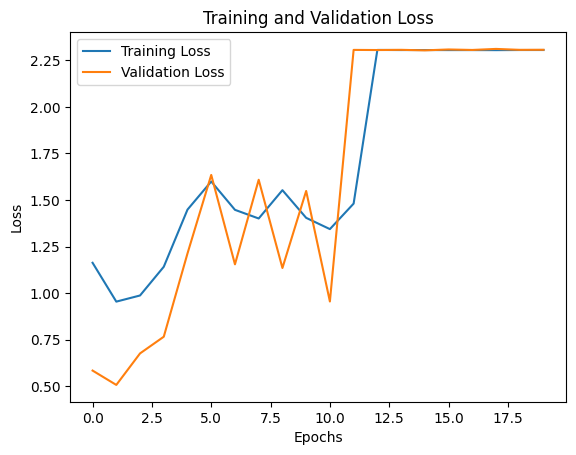

In [30]:
plot_training_validation_loss(point_05_model_history)

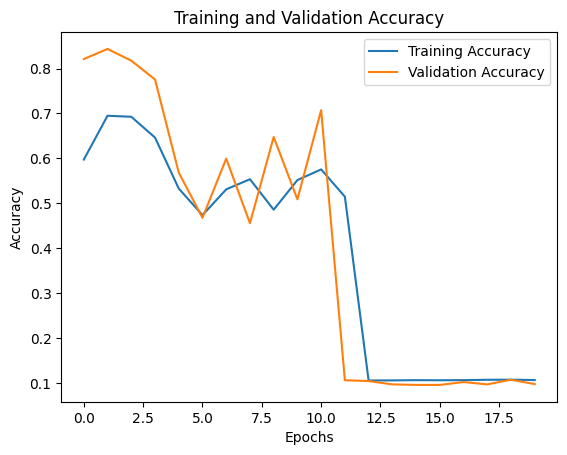

In [31]:
plot_training_validation_accuracy(point_05_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.10      1.00      0.17       958
           7       0.00      0.00      0.00      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



<Figure size 2000x3000 with 0 Axes>

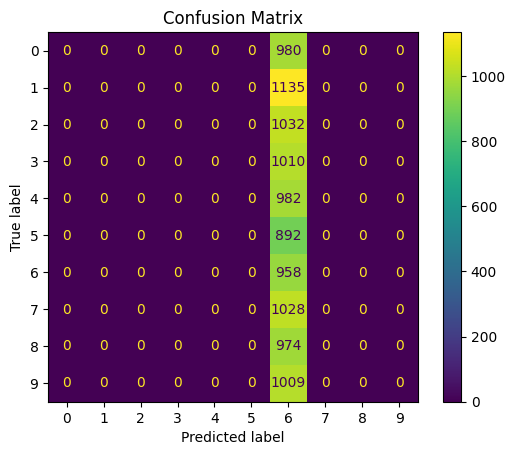

In [32]:
predict_and_print_reports(point_05_model)

### Learning rate: 0.02

In [33]:
point_02_model = Sequential()
point_02_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_02_model.add(MaxPooling2D(pool_size=(2,2)))

point_02_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_02_model.add(MaxPooling2D(pool_size=(2,2)))

point_02_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_02_model.add(MaxPooling2D(pool_size=(2,2)))

point_02_model.add(Flatten())
point_02_model.add(Dense(128, activation="relu"))
point_02_model.add(Dropout(0.5))
point_02_model.add(Dense(len(unique_labels), activation="softmax"))

point_02_model.summary()


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 2, 2, 128)       

In [34]:
point_02_model_history = compile_and_fit_model(
    point_02_model, x_train, train_datagen, epochs=20, learning_rate=0.02
)

Epoch 1/20


2023-05-02 06:25:46.912197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 27s 15ms/step - loss: 0.9708 - accuracy: 0.6593 - val_loss: 0.2742 - val_accuracy: 0.9104
Epoch 2/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.4734 - accuracy: 0.8467 - val_loss: 0.3105 - val_accuracy: 0.8876
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.3925 - accuracy: 0.8717 - val_loss: 0.1594 - val_accuracy: 0.9504
Epoch 4/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3695 - accuracy: 0.8813 - val_loss: 0.1764 - val_accuracy: 0.9454
Epoch 5/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3354 - accuracy: 0.8930 - val_loss: 0.1678 - val_accuracy: 0.9476
Epoch 6/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3230 - accuracy: 0.8965 - val_loss: 0.2183 - val_accuracy: 0.9368
Epoch 7/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3124 - accuracy: 0.9005 - val_loss: 0.1633 - val_accura

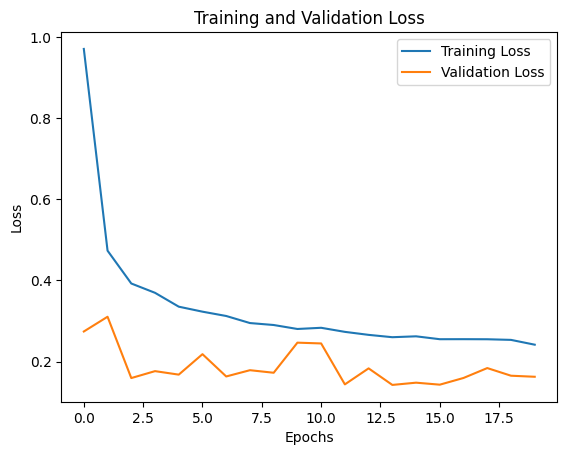

In [36]:
plot_training_validation_loss(point_02_model_history)

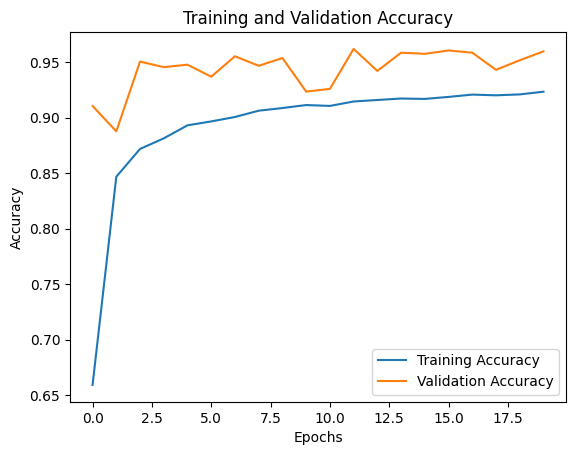

In [37]:
plot_training_validation_accuracy(point_02_model_history)

313/313 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.93      0.96      0.94      1032
           3       0.98      0.99      0.99      1010
           4       0.96      0.99      0.97       982
           5       0.96      0.92      0.94       892
           6       0.91      0.89      0.90       958
           7       0.94      0.98      0.96      1028
           8       1.00      0.98      0.99       974
           9       0.91      0.89      0.90      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



<Figure size 2000x3000 with 0 Axes>

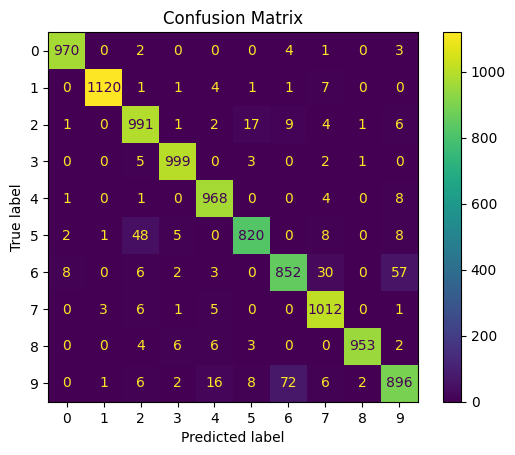

In [38]:
predict_and_print_reports(point_02_model)

### Learning rate: 0.03 no dropout

In [40]:
point_03_nodrop_model = Sequential()
point_03_nodrop_model.add(
    Conv2D(filters=32, kernel_size=(3,3), input_shape=x_train[0].shape, activation="relu", padding="same")
)
point_03_nodrop_model.add(MaxPooling2D(pool_size=(2,2)))

point_03_nodrop_model.add(Conv2D(filters=64, kernel_size=(3,3), activation="relu"))
point_03_nodrop_model.add(MaxPooling2D(pool_size=(2,2)))

point_03_nodrop_model.add(Conv2D(filters=128, kernel_size=(3,3), activation="relu"))
point_03_nodrop_model.add(MaxPooling2D(pool_size=(2,2)))

point_03_nodrop_model.add(Flatten())
point_03_nodrop_model.add(Dense(128, activation="relu"))
point_03_nodrop_model.add(Dense(len(unique_labels), activation="softmax"))

point_03_nodrop_model.summary()


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 2, 2, 128)      

In [41]:
point_03_nodrop_model_history = compile_and_fit_model(
    point_03_nodrop_model, x_train, train_datagen, epochs=20, learning_rate=0.03
)

Epoch 1/20


2023-05-02 06:39:15.401951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1719/1719 [==============================] - 30s 17ms/step - loss: 0.7022 - accuracy: 0.7558 - val_loss: 0.2696 - val_accuracy: 0.9142
Epoch 2/20
1719/1719 [==============================] - 27s 16ms/step - loss: 0.3293 - accuracy: 0.8902 - val_loss: 0.2486 - val_accuracy: 0.9254
Epoch 3/20
1719/1719 [==============================] - 26s 15ms/step - loss: 0.2748 - accuracy: 0.9097 - val_loss: 0.2258 - val_accuracy: 0.9278
Epoch 4/20
1719/1719 [==============================] - 27s 15ms/step - loss: 0.2592 - accuracy: 0.9148 - val_loss: 0.2059 - val_accuracy: 0.9400
Epoch 5/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.2415 - accuracy: 0.9218 - val_loss: 0.2292 - val_accuracy: 0.9408
Epoch 6/20
1719/1719 [==============================] - 28s 16ms/step - loss: 0.2300 - accuracy: 0.9252 - val_loss: 0.2431 - val_accuracy: 0.9262
Epoch 7/20
1719/1719 [==============================] - 27s 15ms/step - loss: 0.2243 - accuracy: 0.9257 - val_loss: 0.1662 - val_accura

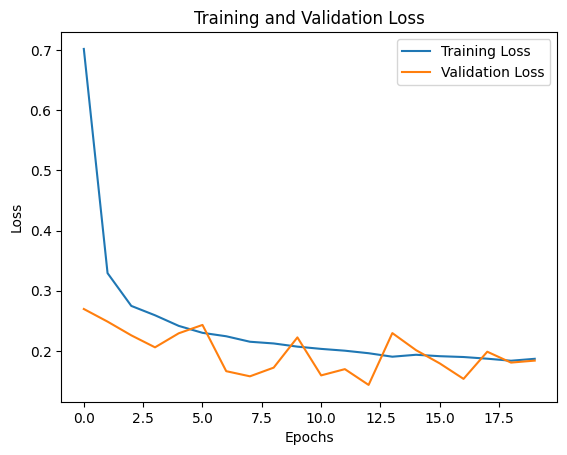

In [63]:
plot_training_validation_loss(point_03_nodrop_model_history)

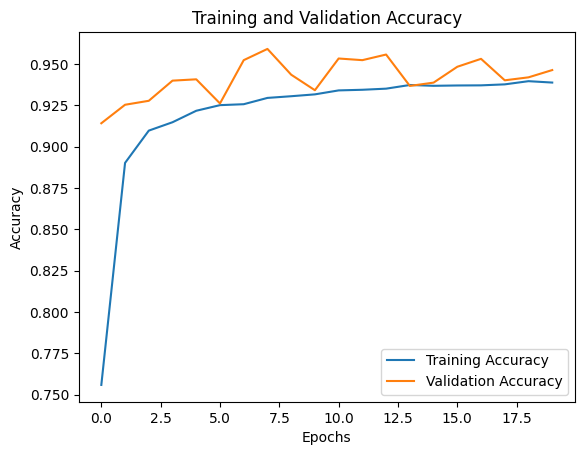

In [64]:
plot_training_validation_accuracy(point_03_nodrop_model_history)

313/313 [==============================] - 1s 2ms/step
Test loss: 0.168
Test accuracy: 0.95
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.91      0.87      0.89      1032
           3       0.96      1.00      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.88      0.91      0.90       892
           6       0.94      0.86      0.90       958
           7       0.95      0.96      0.96      1028
           8       0.98      0.99      0.99       974
           9       0.89      0.94      0.92      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



<Figure size 2000x3000 with 0 Axes>

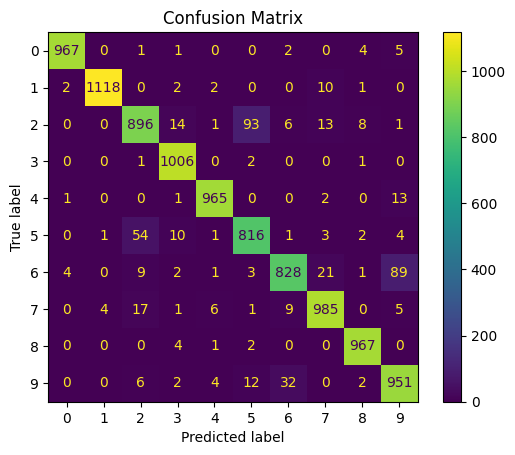

In [73]:
predict_and_print_reports(point_03_nodrop_model)